Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [9]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/data/Skin_cancer_ISIC_Skin_Imaging/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/data/Skin_cancer_ISIC_Skin_Imaging/Test')

In [10]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [11]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [12]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            seed =123,
            validation_split=0.2,
            subset = "training",
            image_size=(img_height , img_width),
            batch_size = batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [13]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            seed =123,
            validation_split=0.2,
            subset = "validation",
            image_size=(img_height , img_width),
            batch_size = batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [14]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

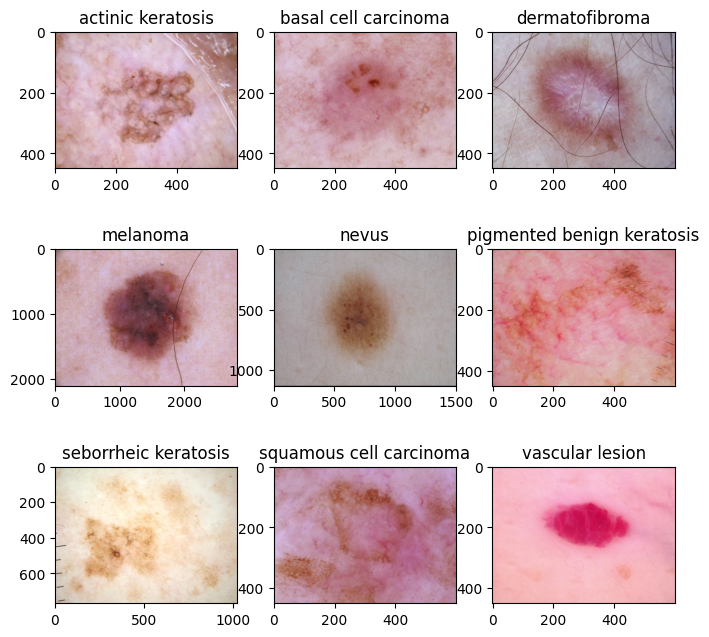

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

for class_id  in range(len(class_names)):
  plt.subplot(3, 3, class_id + 1)
  img = plt.imread(str(list(data_dir_train.glob(class_names[class_id]+'/*.jpg'))[1]))
  plt.title(class_names[class_id])
  plt.imshow(img)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
### Your code goes here
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout

num_classes = 9

def create_cnn_classifier_model():
  model = keras.Sequential()
  model.add(keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))
  model.add(Conv2D(32,(3,3),padding = 'same', activation ='relu', input_shape = (img_height, img_width, 32)))
  model.add(Conv2D(32, (3,3),padding = 'same', activation ='relu',strides=(1,1)))
  model.add(MaxPool2D((2,2), strides=(1,1)))
  model.add(Conv2D(64, (3,3),padding = 'same', activation ='relu',strides=(1,1)))
  model.add(Conv2D(64, (5,5),padding = 'same', activation ='relu',strides=(1,1)))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(128, (3,3),padding = 'same',activation ='relu', strides=(2,2)))
  model.add(Conv2D(128, (5,5),padding = 'same',activation ='relu', strides=(1,1)))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(num_classes, activation = "softmax"))
  
  return model


model = create_cnn_classifier_model()
#print(model.summary())

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
### Todo, choose an appropirate optimiser and loss function

# SparseCategoricalCrossentropy:  Suitable for multi-class classification problems.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 179, 179, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 179, 179, 64)      18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 179, 179, 64)      102464    
                                                      

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 426s 2s/step - loss: 2.0673 - accuracy: 0.1914 - val_loss: 2.0356 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 13s 229ms/step - loss: 2.0145 - accuracy: 0.2277 - val_loss: 2.0438 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 13s 228ms/step - loss: 1.9847 - accuracy: 0.2444 - val_loss: 2.0303 - val_accuracy: 0.2103
Epoch 4/20
56/56 [==============================] - 13s 227ms/step - loss: 1.9541 - accuracy: 0.2388 - val_loss: 1.8930 - val_accuracy: 0.3065
Epoch 5/20
56/56 [==============================] - 13s 240ms/step - loss: 1.7820 - accuracy: 0.3287 - val_loss: 1.7760 - val_accuracy: 0.3445
Epoch 6/20
56/56 [==============================] - 13s 229ms/step - loss: 1.6512 - accuracy: 0.4046 - val_loss: 1.6236 - val_accuracy: 0.4116
Epoch 7/20
56/56 [==============================] - 13s 229ms/step - loss: 1.5582 - accuracy: 0.4235 - val_loss: 1.6749 - val_accuracy: 0.3669
Epoch 8/20
5

### Visualizing training results

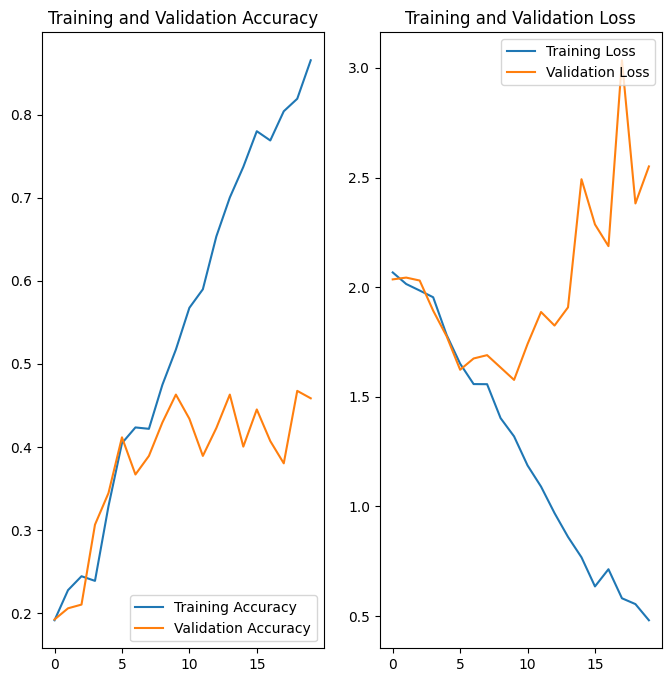

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


#### Observations on Initial Model


*   Model is OverFit, By seeing the graphs
     -  where we can observe difference between Training and Validation loss is increasing
     - Training Accuracy went up to 80-90% but when it comes to validation it is around 45-50% only 











### Write your findings here

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(factor=(-0.2, 0.3), fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

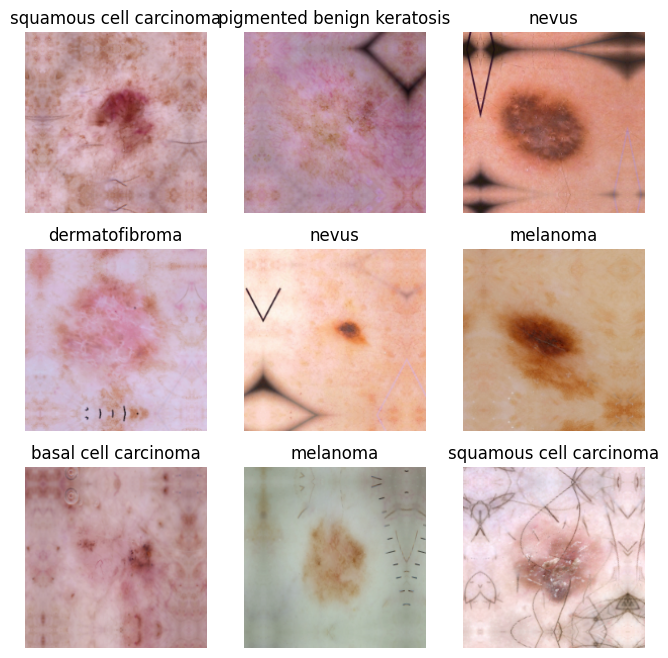

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(8,8))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


### Todo:
### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here


def create_cnn_classifier_model_with_agumented_data(data_updated):
  model = Sequential([data_updated,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
  model.add(Conv2D(32,(3,3),padding = 'same', activation ='relu', input_shape = (img_height, img_width, 32)))
  model.add(Conv2D(32, (3,3),padding = 'same', activation ='relu',strides=(1,1)))
  model.add(MaxPool2D((2,2), strides=(1,1)))
  model.add(Conv2D(64, (3,3),padding = 'same', activation ='relu',strides=(1,1)))
  model.add(Conv2D(64, (5,5),padding = 'same', activation ='relu',strides=(1,1)))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(128, (3,3),padding = 'same',activation ='relu', strides=(2,2)))
  model.add(Conv2D(128, (5,5),padding = 'same',activation ='relu', strides=(1,1)))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(num_classes, activation = "softmax"))
  
  return model



In [23]:
model = create_cnn_classifier_model_with_agumented_data(data_augument)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 179, 179, 32)     0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 179, 179, 64)      18496     
                                                      

### Compiling the model

In [24]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [25]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
56/56 [==============================] - 17s 252ms/step - loss: 2.0730 - accuracy: 0.1769 - val_loss: 2.0253 - val_accuracy: 0.1611
Epoch 2/20
56/56 [==============================] - 13s 234ms/step - loss: 2.0165 - accuracy: 0.2254 - val_loss: 2.0182 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 13s 233ms/step - loss: 1.9739 - accuracy: 0.2489 - val_loss: 1.9008 - val_accuracy: 0.3199
Epoch 4/20
56/56 [==============================] - 13s 232ms/step - loss: 1.9369 - accuracy: 0.2651 - val_loss: 1.8406 - val_accuracy: 0.3221
Epoch 5/20
56/56 [==============================] - 13s 233ms/step - loss: 1.8889 - accuracy: 0.2997 - val_loss: 1.8456 - val_accuracy: 0.3020
Epoch 6/20
56/56 [==============================] - 13s 233ms/step - loss: 1.7551 - accuracy: 0.3477 - val_loss: 1.6420 - val_accuracy: 0.4094
Epoch 7/20
56/56 [==============================] - 13s 234ms/step - loss: 1.8659 - accuracy: 0.3158 - val_loss: 1.7477 - val_accuracy: 0.3468

### Visualizing the results

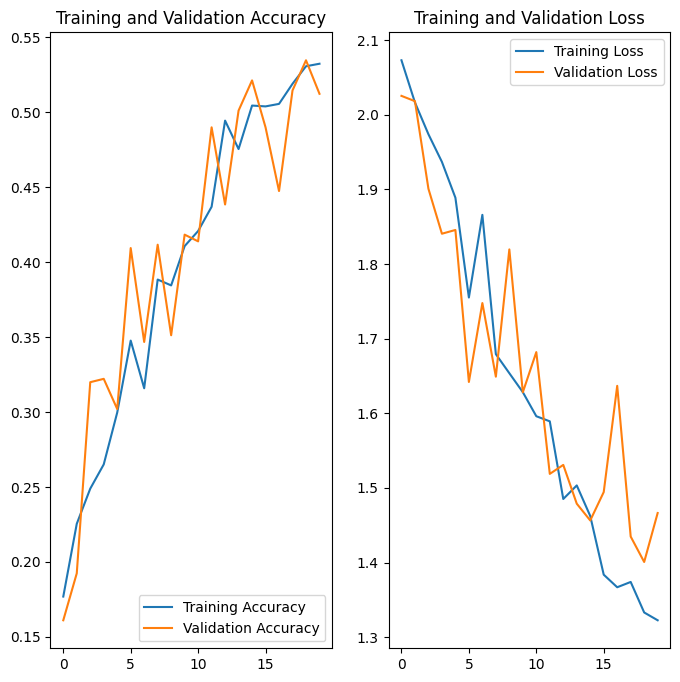

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Observations on the Model uisng Agumented Data


-  where we can observe Over fitting was resolved, seems both Training and validation accurace and Losss at same level 
- But overall accuracy got dropped  from 90% to 55%

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df.head()

,Path,Label
0,/content/gdrive/MyDrive/data/Skin_cancer_ISIC_...,actinic keratosis
1,/content/gdrive/MyDrive/data/Skin_cancer_ISIC_...,actinic keratosis
2,/content/gdrive/MyDrive/data/Skin_cancer_ISIC_...,actinic keratosis
3,/content/gdrive/MyDrive/data/Skin_cancer_ISIC_...,actinic keratosis
4,/content/gdrive/MyDrive/data/Skin_cancer_ISIC_...,actinic keratosis


In [28]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df.head()


,Path,Label
0,/content/gdrive/MyDrive/data/Skin_cancer_ISIC_...,actinic keratosis
1,/content/gdrive/MyDrive/data/Skin_cancer_ISIC_...,actinic keratosis
2,/content/gdrive/MyDrive/data/Skin_cancer_ISIC_...,actinic keratosis
3,/content/gdrive/MyDrive/data/Skin_cancer_ISIC_...,actinic keratosis
4,/content/gdrive/MyDrive/data/Skin_cancer_ISIC_...,actinic keratosis


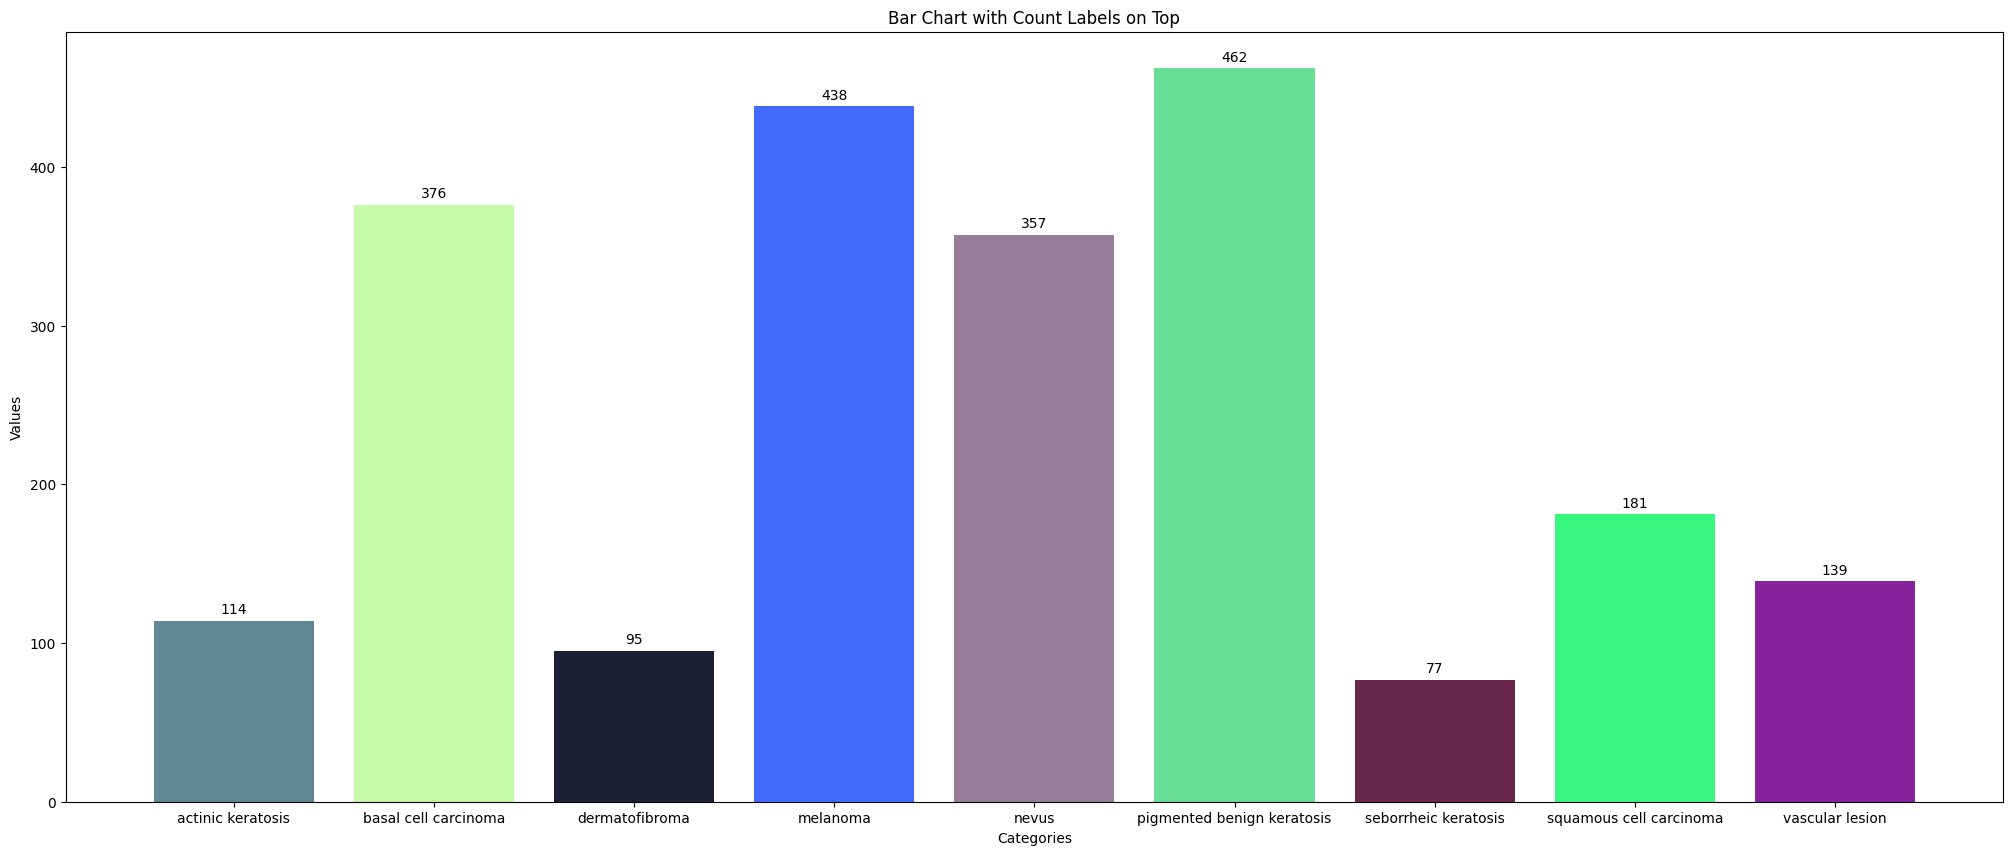

In [29]:
# Generate Random color for better visibility
import random

random_colors = []
for _ in range(num_classes):
    random_color = '#' + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)])
    random_colors.append(random_color)

count=[]

for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
bars = plt.bar(class_names,count,color=random_colors)

for bar in bars:
    height = bar.get_height()
    plt.annotate(str(height), xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords='offset points',
                 ha='center', va='bottom')

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Chart with Count Labels on Top')

# Display the chart
plt.show()


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

* seborrheic keratosis has least number of samples - 77

#### - Which classes dominate the data in terms proportionate number of samples?


*   pigmented benign keratosis
*   melanoma
*   basal cell carcinoma and 
*   nevus


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import Augmentor

In [34]:
train_dir = "/content/gdrive/MyDrive/data/Skin_cancer_ISIC_Skin_Imaging/Train/"


for i in class_names:
    p = Augmentor.Pipeline(pathlib.Path(train_dir + i), output_directory= pathlib.Path(train_dir + i+"/output/"))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(probability=0.5)
    p.zoom(probability=0.2, min_factor=0.8, max_factor=1.2)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

 

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Skin_cancer_ISIC_Skin_Imaging/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F67DB673E20>: 100%|██████████| 500/500 [00:24<00:00, 20.80 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Skin_cancer_ISIC_Skin_Imaging/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F67DB673190>: 100%|██████████| 500/500 [00:22<00:00, 22.64 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Skin_cancer_ISIC_Skin_Imaging/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F67DC50B2B0>: 100%|██████████| 500/500 [00:24<00:00, 20.55 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Skin_cancer_ISIC_Skin_Imaging/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F67DC52D840>: 100%|██████████| 500/500 [02:05<00:00,  3.98 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Skin_cancer_ISIC_Skin_Imaging/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F689BEE7010>: 100%|██████████| 500/500 [01:43<00:00,  4.83 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Skin_cancer_ISIC_Skin_Imaging/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F67DC690A30>: 100%|██████████| 500/500 [00:22<00:00, 22.56 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Skin_cancer_ISIC_Skin_Imaging/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F67DC6BC850>: 100%|██████████| 500/500 [00:53<00:00,  9.27 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Skin_cancer_ISIC_Skin_Imaging/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F67DC5B4610>: 100%|██████████| 500/500 [00:23<00:00, 21.53 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Skin_cancer_ISIC_Skin_Imaging/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F67DB672D40>: 100%|██████████| 500/500 [00:22<00:00, 22.04 Samples/s]


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
data_dir_train_output = pathlib.Path("/content/gdrive/MyDrive/data/Skin_cancer_ISIC_Skin_Imaging/Train/")

image_count_train = len(list(data_dir_train_output.glob('**/*.jpg')))

#image_count_train = len(list(data_dir_train_output.glob('*/output/*.jpg')))
print(image_count_train)

6739


### Lets see the distribution of augmented data after adding new images to the original training data.

In [37]:
path_list=[]
lesion_list=[]

data_dir_train = "/content/gdrive/MyDrive/data/Skin_cancer_ISIC_Skin_Imaging/Train/"


for i in class_names:
    data_dir_train_output_temp = pathlib.Path(data_dir_train + i)
    for j in data_dir_train_output_temp.glob('**/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df.head()
print(new_df.size)


13478


In [38]:
new_df['Label'].value_counts()


pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [39]:
batch_size = 32
img_height = 180
img_width = 180

In [41]:
import pathlib

data_dir_train=pathlib.Path(data_dir_train)

image_count_train1 = len(list(data_dir_train.glob('**/*.jpg')))
print(image_count_train1)


6739


#### **Todo:** Create a training dataset

In [42]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [47]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout

num_classes = 9

def create_cnn_classifier_model_with_agumented_new_data():
  model = Sequential([
                  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
  model.add(Conv2D(32,(3,3),padding = 'same', activation ='relu', input_shape = (img_height, img_width, 32)))
  model.add(Conv2D(32, (3,3),padding = 'same', activation ='relu',strides=(1,1)))
  model.add(MaxPool2D((2,2), strides=(1,1)))
  model.add(Conv2D(64, (3,3),padding = 'same', activation ='relu',strides=(1,1)))
  model.add(Conv2D(64, (5,5),padding = 'same', activation ='relu',strides=(1,1)))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(128, (3,3),padding = 'same',activation ='relu', strides=(2,2)))
  model.add(Conv2D(128, (5,5),padding = 'same',activation ='relu', strides=(1,1)))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(num_classes, activation = "softmax"))
  
  return model


In [48]:
model = create_cnn_classifier_model_with_agumented_new_data()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 179, 179, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 179, 179, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 179, 179, 64)      102464    
                                                      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [49]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [50]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 824s 5s/step - loss: 2.0059 - accuracy: 0.2226 - val_loss: 1.7519 - val_accuracy: 0.3341
Epoch 2/50
169/169 [==============================] - 48s 275ms/step - loss: 1.6958 - accuracy: 0.3448 - val_loss: 1.6437 - val_accuracy: 0.3705
Epoch 3/50
169/169 [==============================] - 46s 264ms/step - loss: 1.6212 - accuracy: 0.3802 - val_loss: 1.6322 - val_accuracy: 0.3690
Epoch 4/50
169/169 [==============================] - 47s 272ms/step - loss: 1.5503 - accuracy: 0.4121 - val_loss: 1.5561 - val_accuracy: 0.4128
Epoch 5/50
169/169 [==============================] - 48s 273ms/step - loss: 1.4842 - accuracy: 0.4316 - val_loss: 1.5997 - val_accuracy: 0.3846
Epoch 6/50
169/169 [==============================] - 46s 265ms/step - loss: 1.3946 - accuracy: 0.4624 - val_loss: 1.4219 - val_accuracy: 0.4350
Epoch 7/50
169/169 [==============================] - 46s 266ms/step - loss: 1.2920 - accuracy: 0.5161 - val_loss: 1.3460 - val_accuracy: 0.478

#### **Todo:**  Visualize the model results

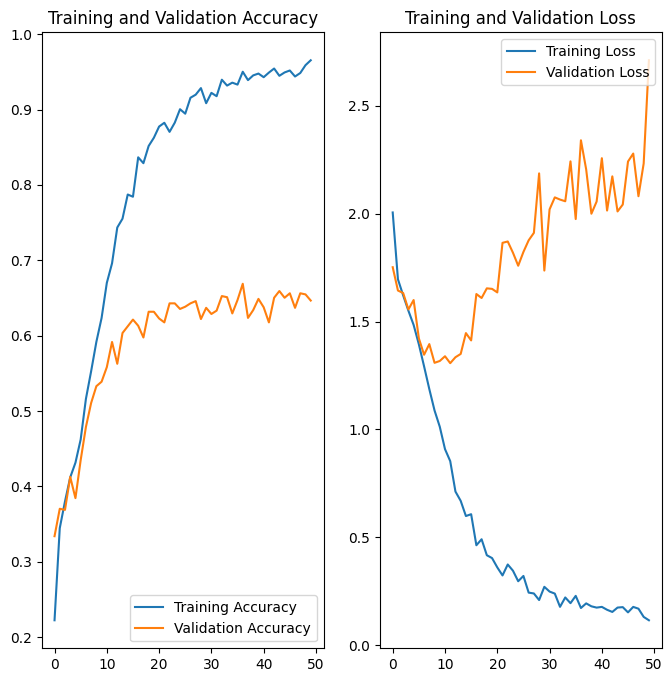

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?




*   With help of Augmentor generated data, Overall Accuracy increased very well 
   - Training Acuracy - around 95%
   - Validation Accruracu  - around 65%
*   Overall Loss 
   - Training Loss - less than .25
   - Validation Loss  - between 2.0 to 2.5

*   Still Model is seems overfitting a bit, will can be fine tuned by modifying hyper parameters 
  